In [1]:
library(Matrix)
library(mvtnorm)
library(hexbin)
library(ggplot2)
library(gtools)
library(rhdf5)
suppressMessages(library(sn))
library(dplyr)
library(tidyr)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




# Define parameters
- number of features (`nGenes`)
- number of guides in guide library (`nGuides`)
- number of cells in simulated dataset (`nCells`)
- number of S cycle genes (`n.s.genes`) - represented by genes with index `1:n.s.genes` 
- number of G2M cycle genes (`n.g2m.genes`) - represented by genes with index `n.s.genes + 1:n.s.genes + n.g2m.genes + 1`
- proportion of cells in dataset in S phase (`propS`)
- proportion of cells in dataset in G2 phase (`propG2`)

In [2]:
nGenes=13000
# nGuides=6000
# nGuides = 2000
nTargets = 1000
# nCells=250000
nCells = 50000
d = 2
nGuides = d*nTargets

# Simulate $\beta_0$

In [3]:
baselines <- rnorm(nGenes, mean = 2.24, sd = 1.8)

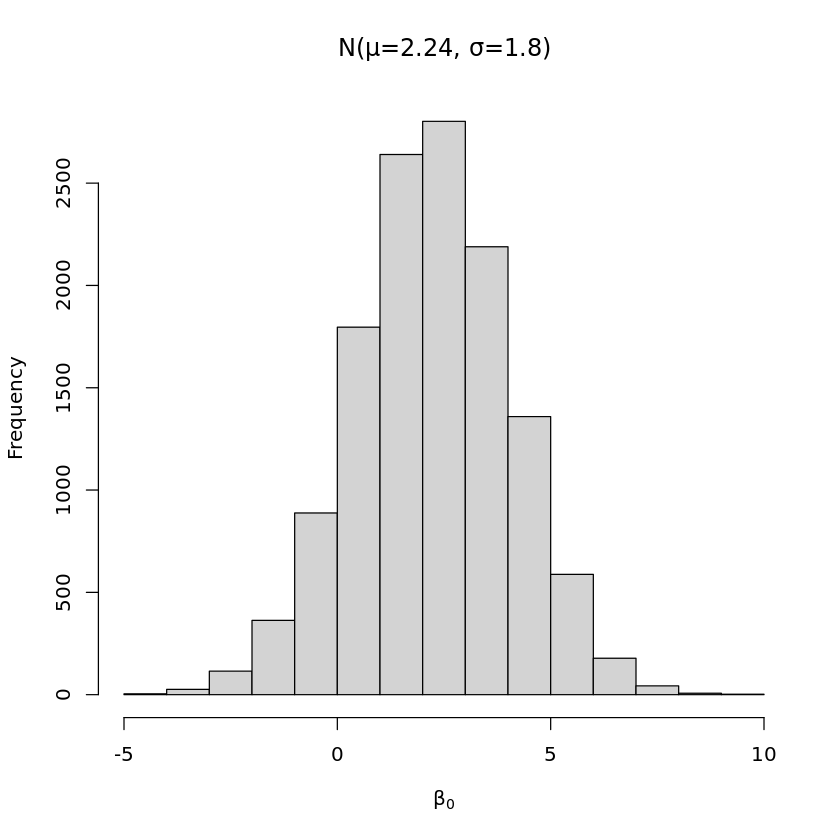

In [4]:
hist(baselines, xlab = expression(beta[0]), 
     main = expression(paste("N(", mu, "=2.24, ", sigma,
    "=1.8)")))

# Assign guides to cells

In [4]:
# represents MOI - parameterization of Poison for assigning # guides per cell
lambda = c(15, 50, 100)

# lambda = 15

In [5]:
# compute number of guides
num.guides = d * nTargets

sprintf("%d unique gRNAs with %d gRNAs per target (%d total targets)", num.guides, d, nTargets)

# initialize one hot encoding
onehot.guides <- matrix(0, nCells, num.guides)

# get nr of guides per cell
guides.per.cell <- rpois(nCells, lambda)

[1] "2000 unique gRNAs with 2 gRNAs per target (1000 total targets)"

Assign number of guides per cell 

In [7]:
guides.per.cell.list <- lapply(lambda, function(x) {rpois(nCells, x)})
# names(guides.per.cell.list) <- lambda

In [8]:
guides.per.cell.plotdf <- data.frame(guides.per.cell.list)
colnames(guides.per.cell.plotdf) <- lambda
guides.per.cell.plotdf$cell <- 1:nCells

guides.per.cell.plotdf <- guides.per.cell.plotdf %>% pivot_longer(-cell, names_to = "lambda", values_to = "nguides")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



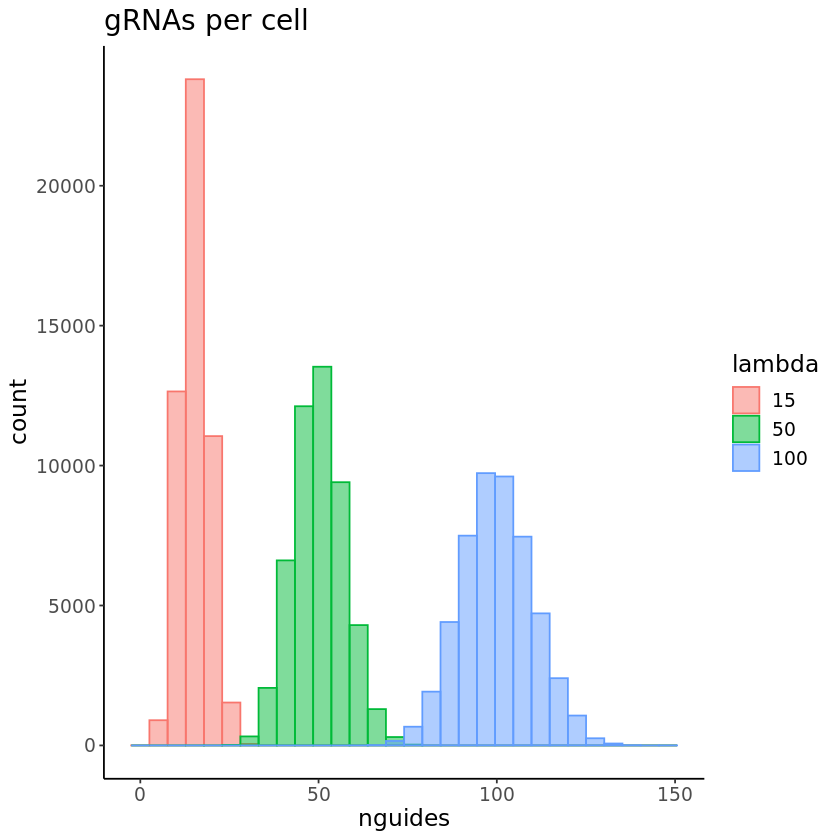

In [9]:
guides.per.cell.plotdf$lambda <- factor(guides.per.cell.plotdf$lambda, levels = sort(lambda))

guides.per.cell.hist <- ggplot(guides.per.cell.plotdf, aes(x = nguides, color = lambda, fill = lambda)) + 
                            geom_histogram(alpha = 0.5, position = "identity") + 
                            theme_classic() +
                            theme(text = element_text(size = 14)) +
                            ggtitle("gRNAs per cell")
guides.per.cell.hist

In [10]:
pdf("../guides_per_cell_lambdas_histogram.pdf", width=4 , height=4)

print(
ggplot(guides.per.cell.plotdf, aes(x = nguides, color = lambda, fill = lambda)) + 
                    geom_histogram(alpha = 0.5, position = "identity") + 
                    theme_classic() +
                    theme(text = element_text(size = 14)) +
                    ggtitle("gRNAs per cell")
)

dev.off()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



png 
  2

Generate one-hot encoded matrices recording guides per cell - for multiple values of lambda

In [13]:
onehot.matrices.list <- list()

for (i in 1:length(lambda)) {
    onehot.guides <- matrix(0, nCells, num.guides)

    l <- lambda[i]
    cat(sprintf("lambda = %d\n", l))
    
    gpc <- guides.per.cell.list[[i]] 
    
    # assign guides to each cell
    guides.idx.list <- sapply(gpc, function(x) {
        sample(1:num.guides, x, replace = FALSE)
        })
    
    # update one hot encoding
    for (j in 1:nCells) {
        guides.idx <- guides.idx.list[[j]]
        onehot.guides[j, guides.idx] <- 1
    }
    
    onehot.matrices.list[[i]] <- onehot.guides
    
}

lambda = 15
lambda = 50
lambda = 100


Generate one-hot encoded matrices recording guides per cell - for single value of lambda

In [11]:
# assign guides to each cell
guides.idx.list <- sapply(guides.per.cell, function(x) {
    sample(1:num.guides, x, replace = FALSE)
    })

In [12]:
# update one hot encoding
for (i in 1:nCells) {
    guides.idx <- guides.idx.list[[i]]
    onehot.guides[i, guides.idx] <- 1
}

# Assign guides to target sites

In [14]:
guide.target.map <- data.frame(guides = 1:nGuides, target = rep(1:nTargets,d))
head(guide.target.map)

,guides,target
,<int>,<int>
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6


# Assign guide efficiencies

In [15]:
# assign guide efficiencies to guides in library
efficiencies <- rbeta(num.guides, 6,3)

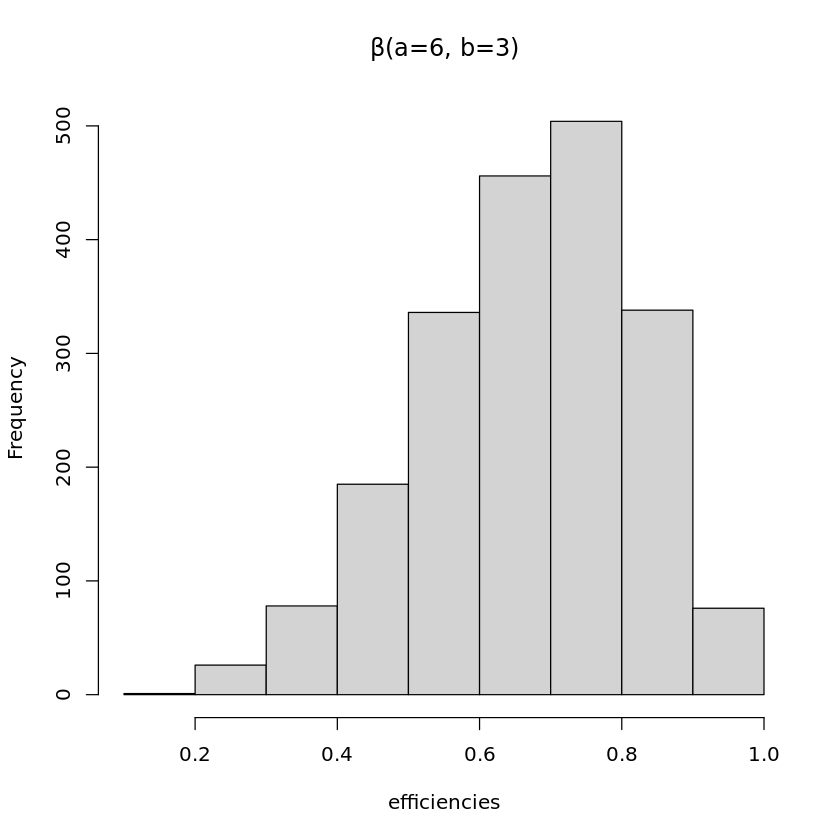

In [16]:
hist(efficiencies,
    main = expression(paste(beta, "(", a, "=6, ", b,
    "=3)")))

In [17]:
guide.target.map$efficiencies <- efficiencies
guide.target.map

guides,target,efficiencies
<int>,<int>,<dbl>
1,1,0.8111105
2,2,0.4629612
3,3,0.4426892
4,4,0.7428814
5,5,0.9223625
6,6,0.7349211
7,7,0.7175786
8,8,0.5859628
9,9,0.2497176


# Assign estimated guide efficiencies

In [18]:
calculate_noisy_efficiency <- function(true, D) {
    a = D*true
    b = a/true - a
    return(rbeta(1,a,b))
}

dispersions <- c(100, 10, 1)
n.disps <- length(dispersions)

noisy.mtx <- matrix(0, length(efficiencies), n.disps)


for (i in 1:n.disps) {
#     D = dispersions[i]
    noisy.mtx[,i] <- sapply(efficiencies, calculate_noisy_efficiency, D = dispersions[i])
}

noisy.df <- data.frame(noisy.mtx)
# rownames(noisy.df) <- 1:length(efficiencies)
# colnames(noisy.df) <- sprintf("D=%d", dispersions)
colnames(noisy.df) <- as.character(dispersions)
noisy.df$guide <- 1:length(efficiencies)
noisy.df$true <- efficiencies
head(noisy.df)

,100,10,1,guide,true
,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,0.4990564,0.3552984,0.6409494,1,0.4901507
2,0.4744601,0.3647742,0.2689452,2,0.4776613
3,0.6107122,0.7097316,0.6395492,3,0.5708801
4,0.7556283,0.7737574,0.9979823,4,0.7620816
5,0.5166048,0.7758237,0.5412174,5,0.5221933
6,0.6359601,0.6263240,0.4895426,6,0.6143574


guide,D,efficiency
<int>,<chr>,<dbl>
1,100,0.4990564
1,10,0.3552984
1,1,0.6409494
1,true,0.4901507
2,100,0.4744601
2,10,0.3647742


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



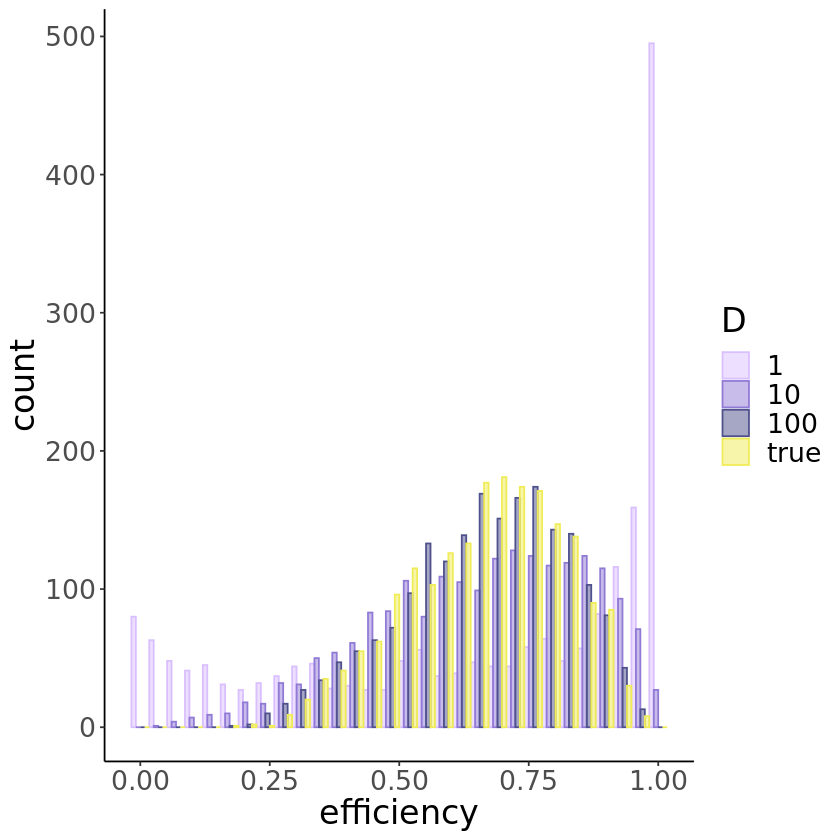

In [19]:
noisy.df.hist <- noisy.df %>% pivot_longer(!guide, names_to = "D", values_to = "efficiency")
head(noisy.df.hist)

group.colors <- c(`1` = "#DABFFF", `10` = "#907AD6", `100` ="#4F518C", `true` = "#F0EC57")

est.efficiencies.hist.p <- ggplot(noisy.df.hist,
                            aes(x = efficiency, fill = D, color = D)) + 
                        geom_histogram(position = "dodge", alpha = 0.5) + 
                        theme_classic() + 
                        theme(text = element_text(size = 20)) + 
scale_fill_manual(values=group.colors) + 
scale_color_manual(values = group.colors)


est.efficiencies.hist.p

# Determine target sites of interest

Target sites = putative enhancers

In [19]:
# total number of targets 
targets <- 1:nTargets
cat(sprintf("number of target sites = %d\n", nTargets))

# total possible target pairs
possible.target.pairs <- combn(targets,2)

cat(sprintf("total possible target pairs = %d\n", dim(possible.target.pairs)[2]))

# # determine percent of possible pairs to define as true interactions
# pct.true.interactions = c(0.001, 0.01, 0.1)

# # see number of pairs for each percentage
# n.pairs <- ceiling(pct.true.interactions*dim(possible.target.pairs)[2])

# # make df and visualize
# interactions.df <- data.frame(pct.pairs = pct.true.interactions, n.pairs = n.pairs)
# interactions.df

number of target sites = 1000
total possible target pairs = 499500


In [20]:
combn(unique(targets), 2)

1,1,1,1,1,1,1,1,1,1,⋯,996,996,996,996,997,997,997,998,998,999
2,3,4,5,6,7,8,9,10,11,⋯,997,998,999,1000,998,999,1000,999,1000,1000


# Identify "ground truth" target site pairs

Here we are predetermining target site pairs that will have an interaction effect.

We will select `n.pairs` cases from the set of possible target pairs.

We will pick `n.pairs=500`.


In [21]:
n.pairs <- 500

# get ix of pairs from possible pairs
ts.pairs.ix <- sample(1:dim(possible.target.pairs)[2], n.pairs, replace = FALSE)

# subset for ix of pairs and convert to df
ts.pairs <- as.data.frame(t(possible.target.pairs[,ts.pairs.ix]))

colnames(ts.pairs) <- c("tsA","tsB")
row.names(ts.pairs) <- 1:n.pairs
head(ts.pairs)

,tsA,tsB
,<int>,<int>
1,691,789
2,119,907
3,54,703
4,662,866
5,351,746
6,12,608


What would it look like if we wanted to select for sets of unique pairs where no target sites were repeated?

In [22]:
possible.target.pairs[,!(duplicated(possible.target.pairs[1,])) & !(duplicated(possible.target.pairs[2]))]

1,2,3,4,5,6,7,8,9,10,⋯,990,991,992,993,994,995,996,997,998,999
2,3,4,5,6,7,8,9,10,11,⋯,991,992,993,994,995,996,997,998,999,1000


# Identify "negative control"

These are pairs with **no** designated interaction effect which we will set aside for testing.

In [23]:
# set number of neg ctrl to number of pairs with interaction 
n.neg = n.pairs

# select neg ctrl cases
possible.neg.ix <- setdiff(1:dim(possible.target.pairs)[2], ts.pairs.ix)
neg.pairs.ix <- sample(possible.neg.ix, n.neg, replace = FALSE)

# convert to df 
neg.ctrl.pairs <- as.data.frame(t(possible.target.pairs[,neg.pairs.ix]))
colnames(neg.ctrl.pairs) <- c("neg.tsA", "neg.tsB")
head(neg.ctrl.pairs)

,neg.tsA,neg.tsB
,<int>,<int>
1,903,909
2,774,918
3,224,762
4,273,952
5,32,99
6,86,433


# Assign target genes to each pair of target sites

In [24]:
# genes that are targeted by pairs with an interaction
target.genes <- sample(1:nGenes, n.pairs, replace = FALSE)

# genes targeted by pairs without interaction
target.genes.neg <- sample(setdiff(1:nGenes, target.genes), n.neg, replace = FALSE)

In [25]:
# map guide pairs to target genes
ts.pairs$target.genes <- target.genes

head(ts.pairs)

,tsA,tsB,target.genes
,<int>,<int>,<int>
1,691,789,1698
2,119,907,10235
3,54,703,10098
4,662,866,3499
5,351,746,11747
6,12,608,12177


In [26]:
neg.ctrl.pairs$target.genes <- target.genes.neg
head(neg.ctrl.pairs)

,neg.tsA,neg.tsB,target.genes
,<int>,<int>,<int>
1,903,909,5309
2,774,918,6265
3,224,762,11613
4,273,952,10123
5,32,99,12003
6,86,433,10138


# Check the number of cells in which each target site pair is perturbed

Do this for each value of lambda (MOI) used.

In [27]:
ncells.per.pair.list <- list()

for (i in 1:length(lambda)) {
    
    one.hot.guides <- onehot.matrices.list[[i]]
    
    ncells <- c()

    for (j in 1:nrow(ts.pairs)) {
        tsA <- ts.pairs[j,]$tsA
        tsB <- ts.pairs[j,]$tsB
        tsA.guides <- guide.target.map %>% filter(target == tsA) %>% pull(guides)
        tsB.guides <- guide.target.map %>% filter(target == tsB) %>% pull(guides)
        cells.with.tsA <- rowSums(one.hot.guides[,tsA.guides])>0
        cells.with.tsB <- rowSums(one.hot.guides[,tsB.guides])>0
        n <- sum(cells.with.tsA & cells.with.tsB)
        ncells[j] <- n
    }
    
    ncells.per.pair.list[[i]] <- ncells
}


In [28]:
ncells.per.pair.df <- data.frame(ncells.per.pair.list)
colnames(ncells.per.pair.df) <- lambda
ncells.per.pair.df$pair <- 1:nrow(ts.pairs)
ncells.per.pair.plotdf <- ncells.per.pair.df %>% pivot_longer(!pair, names_to = "lambda", values_to = "ncells")

Get mean number for each value of lambda

In [29]:
lapply(ncells.per.pair.list, mean)

[[1]]
[1] 11.268

[[2]]
[1] 120.912

[[3]]
[1] 475.398

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



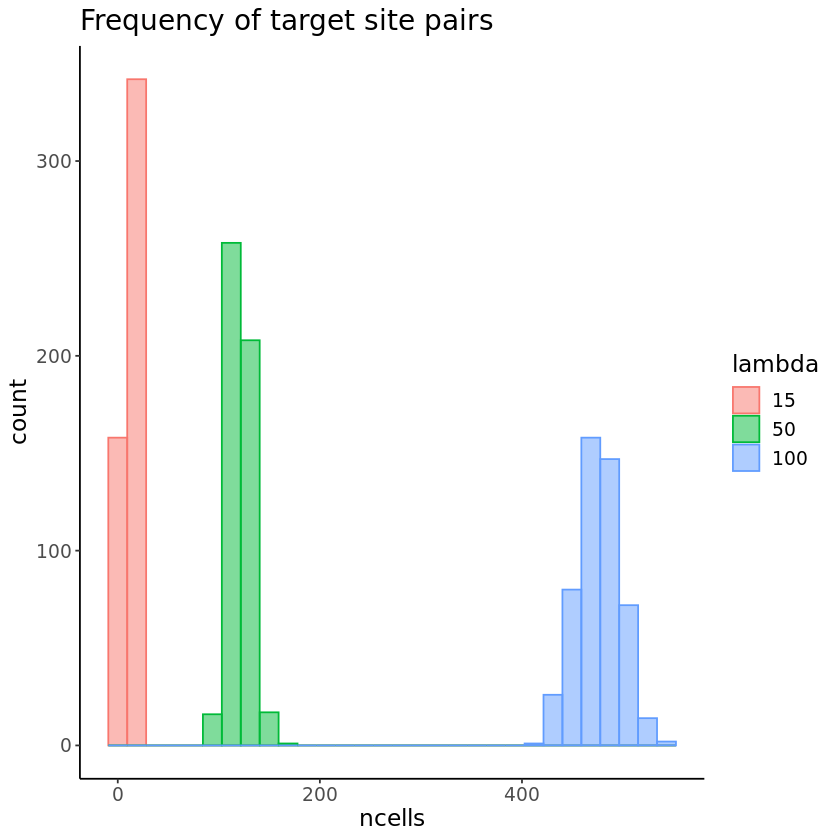

In [30]:
ncells.per.pair.plotdf$lambda <- factor(ncells.per.pair.plotdf$lambda, levels = c(15,50,100))

ts.pair.freq.p <- ggplot(ncells.per.pair.plotdf, aes(x = ncells, color = lambda, fill = lambda)) + 
                    geom_histogram(alpha = 0.5, position = "identity") + 
                    theme_classic() +
                    theme(text = element_text(size = 14)) +
                    ggtitle("Frequency of target site pairs") 

ts.pair.freq.p

In [31]:
pdf("../ts_pair_frequencies_histogram.pdf", width = 4, height = 4)

print(ts.pair.freq.p)

dev.off()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



png 
  2

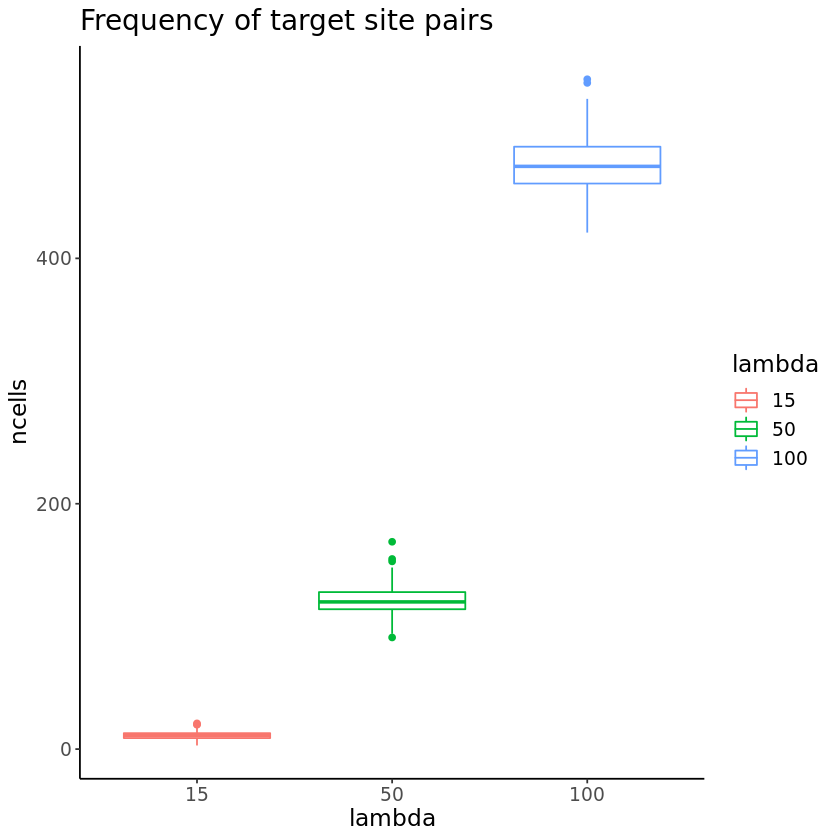

In [31]:
ts.pair.freq.box <- ggplot(ncells.per.pair.plotdf, aes(x = lambda, y = ncells, color = lambda)) + 
                    geom_boxplot() + 
                    theme_classic() +
                    theme(text = element_text(size = 14)) +
                    ggtitle("Frequency of target site pairs")

ts.pair.freq.box

In [33]:
pdf("../ts_pair_frequencies_boxplot.pdf", width = 4, height = 4)

print(ts.pair.freq.box)

dev.off()

png 
  2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



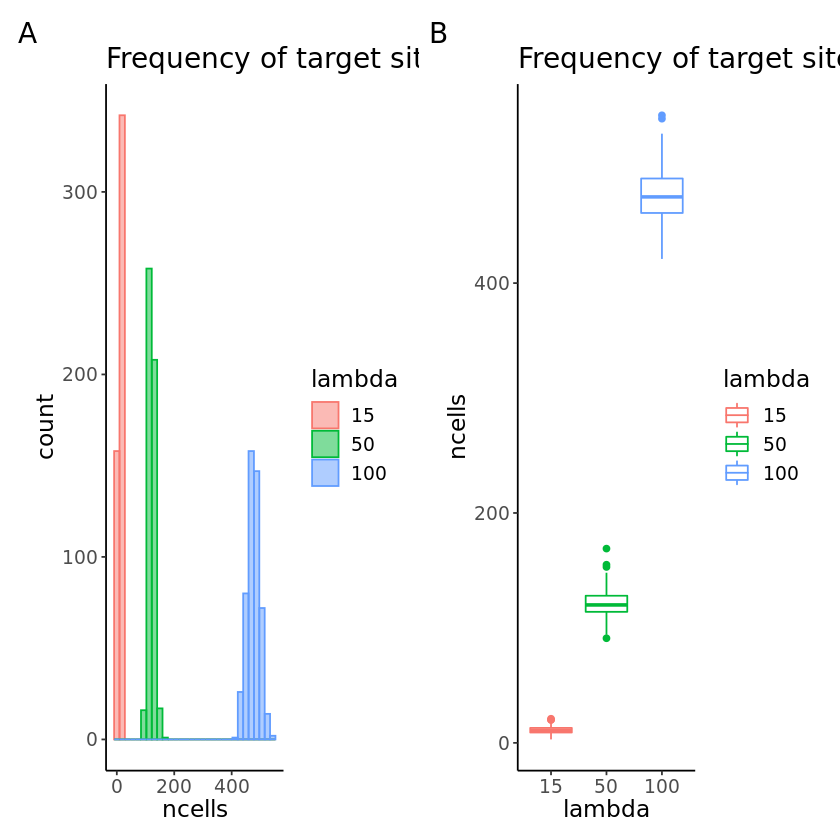

In [32]:
(ts.pair.freq.p  | ts.pair.freq.box) + plot_annotation(tag_levels = "A")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



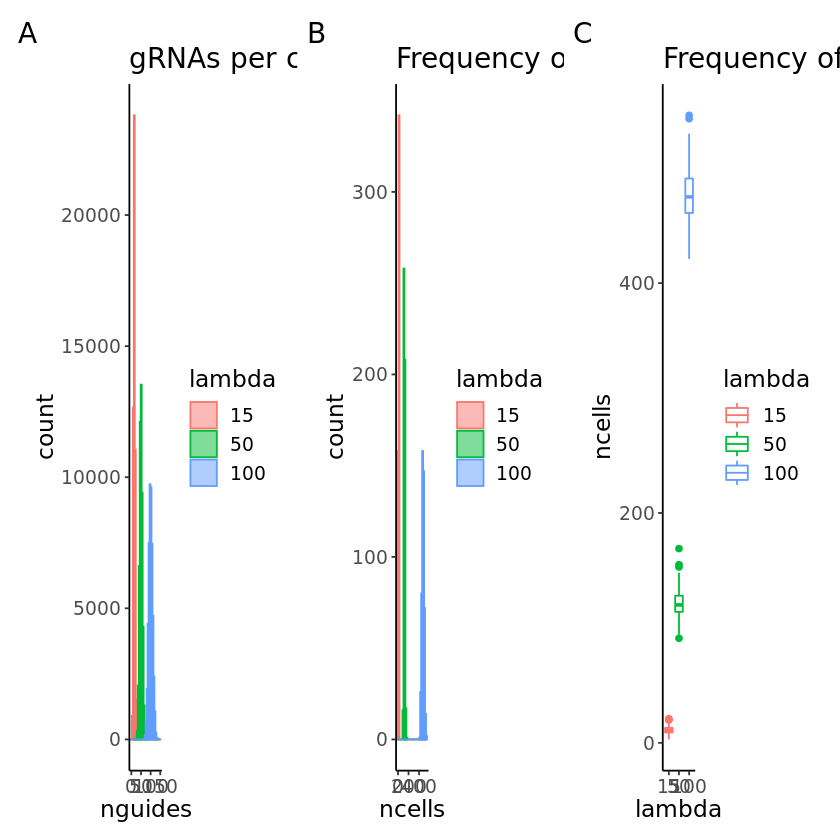

In [33]:
(guides.per.cell.hist | ts.pair.freq.p  | ts.pair.freq.box) + plot_annotation(tag_levels = "A")

In [182]:
pdf("../ts_pair_frequencies_hist_and_box.pdf", width = 8, height = 4)

print(ts.pair.freq.p  | ts.pair.freq.box)

dev.off()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



png 
  2

In [194]:
pdf("../ts_pair_frequencies_hist_and_box_with_plot_tags.pdf", width = 8, height = 4)

(ts.pair.freq.p  | ts.pair.freq.box) + plot_annotation(tag_levels = "A")
dev.off()

png("../ts_pair_frequencies_hist_and_box_with_plot_tags.png", 
    res = 300, units = "in", width = 12, height = 6)

(ts.pair.freq.p  | ts.pair.freq.box) + plot_annotation(tag_levels = "A")
dev.off()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



png 
  2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



png 
  2

In [195]:
pdf("../grna_freq_and_ts_pair_frequencies_hist_and_box_with_plot_tags.pdf", width = 12, height = 4)

((guides.per.cell.hist | ts.pair.freq.p  | ts.pair.freq.box) + plot_annotation(tag_levels = "A")) + plot_annotation(tag_levels = "A")
dev.off()

png("../grna_freq_and_ts_pair_frequencies_hist_and_box_with_plot_tags.png", 
    res = 300, units = "in", width = 16, height = 4)

((guides.per.cell.hist | ts.pair.freq.p  | ts.pair.freq.box) + plot_annotation(tag_levels = "A")) + plot_annotation(tag_levels = "A")
dev.off()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



png 
  2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



png 
  2

# Assign effect sizes for individual target sites on target gene ($\beta_A, \beta_B, \beta_{AB}$)

- positive and negative interaction effects (50/50)
- vary interaction effect size for power analysis

In [34]:
rgammas.list <- lapply(c(6,12,18), function(x) {rgamma(500, shape =x, scale=0.5)})
rgammas.df <- data.frame(rgammas.list)
colnames(rgammas.df) <- c(6,12,18)
rgammas.df$ix <- rownames(rgammas.df)
rgammas.plotdf <- rgammas.df %>% pivot_longer(!ix, names_to="shape",values_to = "rgamma")

In [35]:
rgammas.list <- list(rgamma(500,shape=6,scale=0.5),
                    rgamma(500,shape=96,scale=1/8),
                    rgamma(500,shape=216,scale=1/12))

rgammas.df <- data.frame(rgammas.list)
colnames(rgammas.df) <- c(6,12,18)
rgammas.df$ix <- rownames(rgammas.df)
rgammas.plotdf <- rgammas.df %>% pivot_longer(!ix, names_to="shape",values_to = "rgamma")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



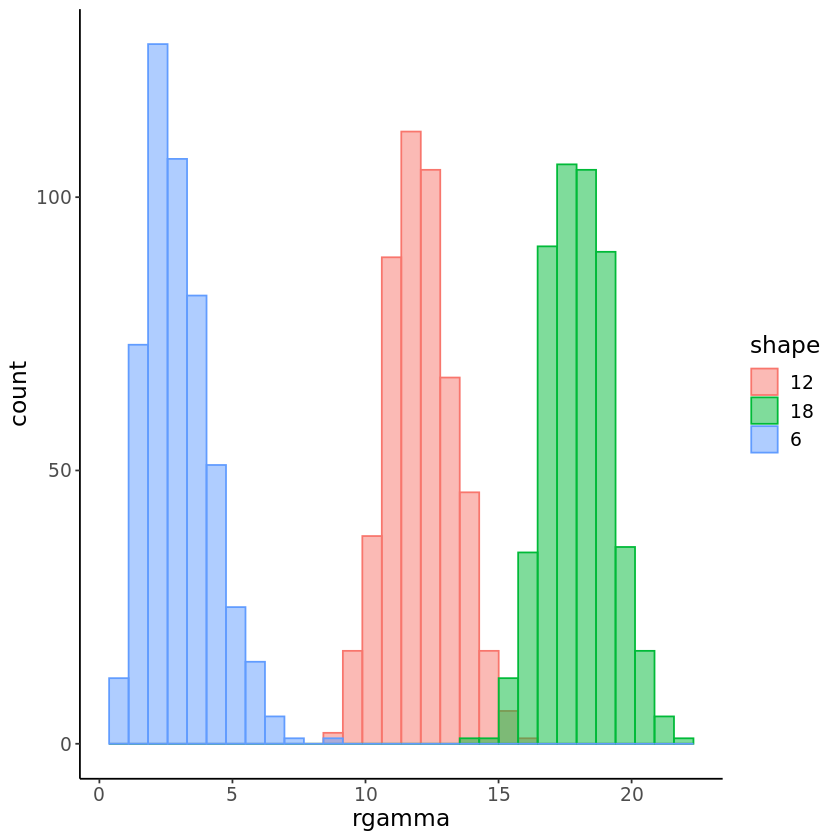

In [36]:
ggplot(rgammas.plotdf, aes(x = rgamma, color = shape, fill = shape)) + 
        geom_histogram(position = "identity", alpha=0.5) +
        theme_classic() +
        theme(text = element_text(size = 14))

In [37]:
pdf("../rgammas_hist.pdf")

print(
    ggplot(rgammas.plotdf, aes(x = rgamma, color = shape, fill = shape)) + 
        geom_histogram(position = "identity", alpha=0.5) +
        theme_classic() +
        theme(text = element_text(size = 14))
    
)

dev.off()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



png 
  2

### Assigning interaction effect sizes from a distribution

In [38]:
assign_ts_effect <- function(df, shape = 6, scale = 0.5, interaction = TRUE) {
    # effect.size is used if interaction is TRUE
    n <- dim(df)[1]
    beta.a <- -1 * (rgamma(n, shape = shape, scale = scale))
    beta.b <- -1 * (rgamma(n, shape = shape, scale = scale))
    df$beta.A <- beta.a
    df$beta.B <- beta.b
    if (interaction) {
        interaction.pos <- 1*rgamma(ceiling(n/2), shape = shape, scale = scale)
        interaction.neg <- rgamma(n-ceiling(n/2), shape = shape, scale = scale)
        interactions <- c(interaction.pos, interaction.neg)
        df$interaction <- interactions 
    }
    return(df)
}

In [39]:
# for positive cases
ts.pairs <- assign_ts_effect(ts.pairs)
neg.ctrl.pairs <- assign_ts_effect(neg.ctrl.pairs, interaction = FALSE)
neg.ctrl.pairs$interaction <- 0

### Assigning fixed interaction effect sizes for power analysis

In [40]:
interaction.sizes <- c(0.5,1,2,3,4,5,6)

In [41]:
ts.pairs$betaA <- -1*rgamma(dim(ts.pairs)[1], shape = 6, scale = 0.5)
ts.pairs$betaB <- -1*rgamma(dim(ts.pairs)[1], shape = 6, scale = 0.5)

neg.ctrl.pairs$betaA <- -1*rgamma(dim(neg.ctrl.pairs)[1], shape = 6, scale = 0.5)
neg.ctrl.pairs$betaB <- -1*rgamma(dim(neg.ctrl.pairs)[1], shape = 6, scale = 0.5)

In [42]:
head(ts.pairs)

,tsA,tsB,target.genes,beta.A,beta.B,interaction,betaA,betaB
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,691,789,1698,-3.251198,-3.134271,3.858576,-6.881088,-4.354471
2,119,907,10235,-2.315713,-1.528599,1.583957,-1.351564,-2.307293
3,54,703,10098,-3.429230,-2.247797,4.056689,-2.201660,-1.859059
4,662,866,3499,-2.070086,-4.243647,1.920008,-3.729987,-1.722228
5,351,746,11747,-1.057500,-1.566833,2.902572,-2.465276,-1.577892
6,12,608,12177,-2.304833,-3.041414,2.583242,-3.435863,-4.599500


In [43]:
head(neg.ctrl.pairs)

,neg.tsA,neg.tsB,target.genes,beta.A,beta.B,interaction,betaA,betaB
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,903,909,5309,-2.403026,-2.243633,0,-6.076118,-2.043432
2,774,918,6265,-4.698615,-2.269695,0,-1.960673,-3.082527
3,224,762,11613,-1.686111,-2.587621,0,-2.987818,-2.506431
4,273,952,10123,-6.059746,-2.844567,0,-2.009671,-1.850711
5,32,99,12003,-3.548882,-3.312947,0,-1.770450,-2.006480
6,86,433,10138,-1.369081,-5.525283,0,-3.351515,-1.648651


In [44]:
neg.ctrl.pairs.tmp <- neg.ctrl.pairs
colnames(neg.ctrl.pairs.tmp)[1:2] <- c("tsA","tsB")
head(neg.ctrl.pairs.tmp)

,tsA,tsB,target.genes,beta.A,beta.B,interaction,betaA,betaB
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,903,909,5309,-2.403026,-2.243633,0,-6.076118,-2.043432
2,774,918,6265,-4.698615,-2.269695,0,-1.960673,-3.082527
3,224,762,11613,-1.686111,-2.587621,0,-2.987818,-2.506431
4,273,952,10123,-6.059746,-2.844567,0,-2.009671,-1.850711
5,32,99,12003,-3.548882,-3.312947,0,-1.770450,-2.006480
6,86,433,10138,-1.369081,-5.525283,0,-3.351515,-1.648651


In [45]:
all.pairs.pos.and.neg <- rbind(ts.pairs, neg.ctrl.pairs.tmp)
all.pairs.pos.and.neg$set <- c(rep("positive", n.pairs), rep("negative", n.neg))

In [46]:
head(all.pairs.pos.and.neg)

,tsA,tsB,target.genes,beta.A,beta.B,interaction,betaA,betaB,set
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,691,789,1698,-3.251198,-3.134271,3.858576,-6.881088,-4.354471,positive
2,119,907,10235,-2.315713,-1.528599,1.583957,-1.351564,-2.307293,positive
3,54,703,10098,-3.429230,-2.247797,4.056689,-2.201660,-1.859059,positive
4,662,866,3499,-2.070086,-4.243647,1.920008,-3.729987,-1.722228,positive
5,351,746,11747,-1.057500,-1.566833,2.902572,-2.465276,-1.577892,positive
6,12,608,12177,-2.304833,-3.041414,2.583242,-3.435863,-4.599500,positive


In [47]:
length(union(unique(all.pairs.pos.and.neg$tsA), unique(all.pairs.pos.and.neg$tsB)))

[1] 859

# Simulate cell cycle scores ($X_S, X_{G2M}$)

In [48]:
# load cell cycle scores
covars <- h5read('/iblm/netapp/data1/external/Gasperini2019/processed/gasperini_data.h5','covariates')
emp.s <- covars$s.score
emp.g2m <- covars$g2m.score

In [49]:
# define optimization fxn for normal
optim_norm <- function(par, data) {
    -sum(dnorm(data, mean = par[1], sd = par[2], log = TRUE))
}


In [50]:
# fit normal distribution to observed S scores
s.score.fit <- optim(c(1,1), optim_norm, data = emp.s, lower = c(-Inf, 1e-10), upper = c(Inf, Inf), method = "L-BFGS-B")

# simulate S scores
s.scores <- rnorm(nCells, mean = s.score.fit$par[1], sd = s.score.fit$par[2])


In [51]:
# fit skew normal to observed G2M scores
g2m.fit <- selm(X ~ 1, data=data.frame(X=emp.g2m))
extractSECdistr(g2m.fit)

# simulate G2M scores (hardcoded based on values in notebook)
g2m.scores <- rsn(n=nCells, xi=-0.2556359, omega=0.3124325, alpha=6.2932919, tau=0, dp=NULL)


Probability distribution of variable 'Fitted SEC distribution of g2m.fit'
Skew-elliptically contoured distribution of univariate family SN 
Direct parameters:
        xi      omega      alpha 
-0.2556359  0.3124325  6.2932919 

In [52]:
cell.cycle.scores <- data.frame(cell = 1:nCells, s = s.scores, g2m = g2m.scores)
cell.cycle.scores.plotdf <- cell.cycle.scores %>% tidyr::pivot_longer(!cell, names_to = "cell cycle", values_to = "score")
head(cell.cycle.scores.plotdf)

cell,cell cycle,score
<int>,<chr>,<dbl>
1,s,0.006961842
1,g2m,-0.180275833
2,s,0.032930779
2,g2m,0.068096875
3,s,-0.108903492
3,g2m,0.605512881


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



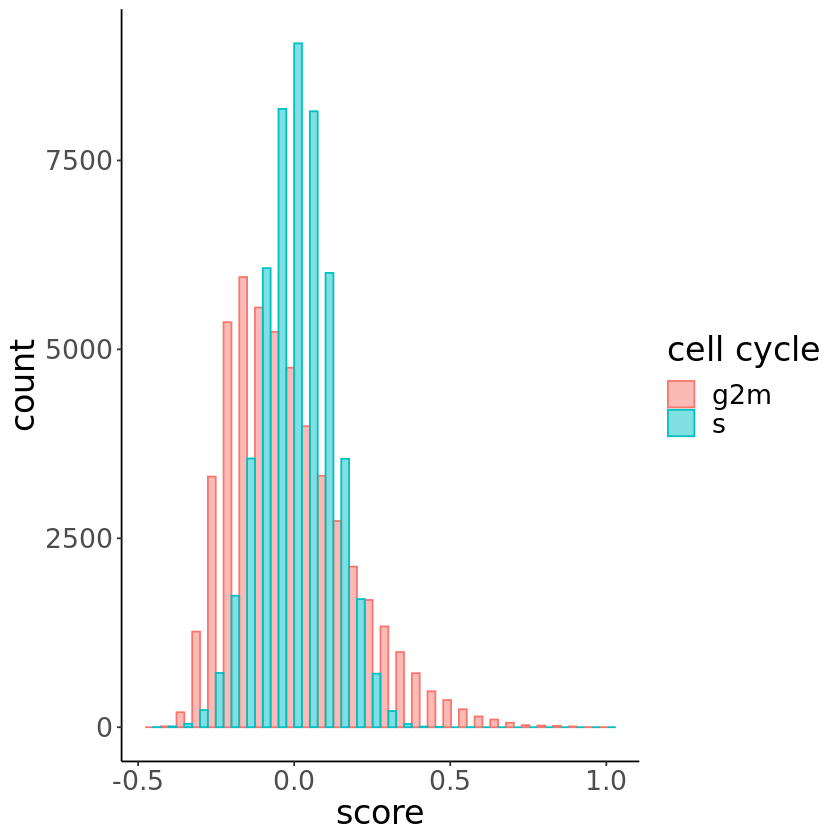

In [53]:
ggplot(cell.cycle.scores.plotdf, aes(x = score, fill = `cell cycle`, color = `cell cycle`)) + 
    geom_histogram(position = "dodge", alpha = 0.5) + theme_classic() + theme(text = element_text(size = 20)) 

# Simulate values of $\beta_S, \beta_{G2M}$ 

From gamma distribution

In [54]:
beta.s <- rgamma(nGenes, shape = 6, scale = 0.5)
beta.g2m <- rgamma(nGenes, shape = 6, scale = 0.5)


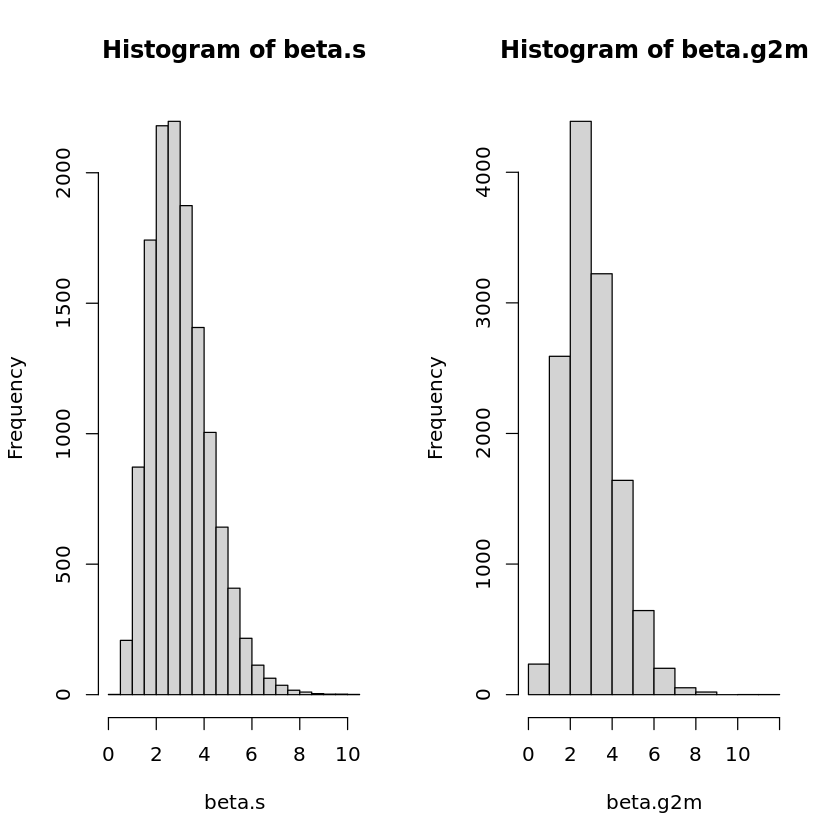

In [55]:
par(mfrow = c(1,2))
hist(beta.s)
hist(beta.g2m)

# Simulate $\beta_{percent.mito}, X_{percent.mito}$

In [56]:
percent.mito <- rbeta(nCells, shape1 = 3.3, shape2 = 81.48)
beta.pct.mito <- rgamma(nGenes, shape = 6 , scale = 0.5)

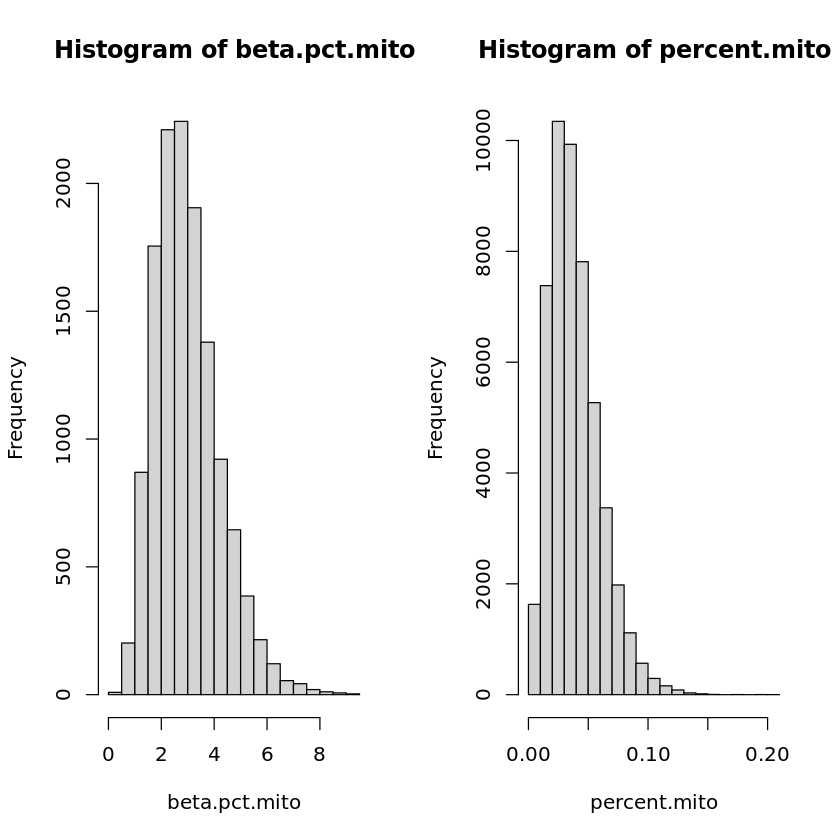

In [57]:
par(mfrow = c(1,2))
hist(beta.pct.mito)
hist(percent.mito)

# Collect all "true" coeff values in data frame

In [58]:
head(all.pairs.pos.and.neg)

,tsA,tsB,target.genes,beta.A,beta.B,interaction,betaA,betaB,set
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,691,789,1698,-3.251198,-3.134271,3.858576,-6.881088,-4.354471,positive
2,119,907,10235,-2.315713,-1.528599,1.583957,-1.351564,-2.307293,positive
3,54,703,10098,-3.429230,-2.247797,4.056689,-2.201660,-1.859059,positive
4,662,866,3499,-2.070086,-4.243647,1.920008,-3.729987,-1.722228,positive
5,351,746,11747,-1.057500,-1.566833,2.902572,-2.465276,-1.577892,positive
6,12,608,12177,-2.304833,-3.041414,2.583242,-3.435863,-4.599500,positive


In [59]:
table(all.pairs.pos.and.neg$set)


negative positive 
     500      500 

In [60]:
# get list of target genes and all genes that are not targeted
all.target.genes <- all.pairs.pos.and.neg$target.gene
nt.genes <- setdiff(1:nGenes, all.target.genes)

print(length(all.target.genes))
print(length(nt.genes))

[1] 1000
[1] 12000


In [61]:
# get table of betaA, betaB, and interaction coeffs for NT genes (0)
# ab.coeffs.nt <- data.frame(gene = nt.genes, beta.A = 0, beta.B = 0, interaction = 0)
ab.coeffs.nt <- data.frame(gene = nt.genes, betaA = 0, betaB = 0)
head(ab.coeffs.nt)

,gene,betaA,betaB
,<int>,<dbl>,<dbl>
1,2,0,0
2,3,0,0
3,4,0,0
4,6,0,0
5,7,0,0
6,8,0,0


In [62]:
# subset coeffs for pos and neg pairs and rename columns to match table for NT genes
# ab.coeffs.targets <- all.pairs.pos.and.neg %>% select(target.genes, beta.A, beta.B, interaction)
ab.coeffs.targets <- all.pairs.pos.and.neg %>% select(target.genes, betaA, betaB)
colnames(ab.coeffs.targets)[1] <- "gene"

In [63]:
head(ab.coeffs.targets)

,gene,betaA,betaB
,<int>,<dbl>,<dbl>
1,1698,-6.881088,-4.354471
2,10235,-1.351564,-2.307293
3,10098,-2.201660,-1.859059
4,3499,-3.729987,-1.722228
5,11747,-2.465276,-1.577892
6,12177,-3.435863,-4.599500


In [64]:
# bind tables
ab.coeffs.all <- rbind(ab.coeffs.targets, ab.coeffs.nt) %>% arrange(gene)
head(ab.coeffs.all)

,gene,betaA,betaB
,<int>,<dbl>,<dbl>
1,1,-2.020065,-1.738071
2,2,0.000000,0.000000
3,3,0.000000,0.000000
4,4,0.000000,0.000000
5,5,-0.883847,-2.269633
6,6,0.000000,0.000000


In [65]:
all.coeffs <- ab.coeffs.all
all.coeffs$beta0 <- baselines
all.coeffs$beta.s <- beta.s
all.coeffs$beta.g2m <- beta.g2m
all.coeffs$percent.mito <- beta.pct.mito

In [66]:
head(all.coeffs)

,gene,betaA,betaB,beta0,beta.s,beta.g2m,percent.mito
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,-2.020065,-1.738071,0.8718550,1.5518641,1.9448970,3.224638
2,2,0.000000,0.000000,1.6533939,2.8469827,3.0179327,2.416789
3,3,0.000000,0.000000,1.0152708,4.7285891,2.4178828,4.018833
4,4,0.000000,0.000000,1.4742127,4.2229374,1.8005837,2.788849
5,5,-0.883847,-2.269633,-0.9383473,0.7778071,0.9311253,2.403031
6,6,0.000000,0.000000,3.2829007,2.5430289,0.7508950,2.457934


# Simulate scaling factors (poisson)

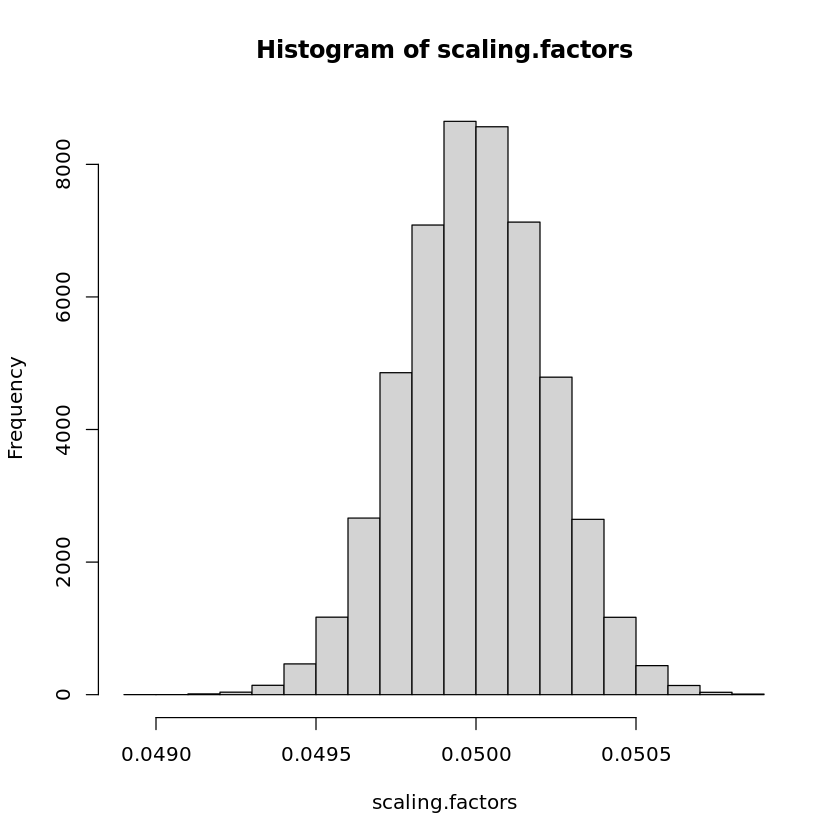

In [67]:
# simulate total counts per cell
t.vec <- rpois(nCells, 50000)

# get scaling factors
scaling.factors <- t.vec / 1e6

hist(scaling.factors)

# Test simulating counts

Testing genes targeted by pair with interaction term (positive)

In [68]:
pos.test.genes <- sample(ts.pairs$target.genes,10, replace = FALSE)
pos.test.genes

[1]     9 12246 12289  6119  8275  5051  5076  4218   438 12864

###### Initialize h5 file for writing simulated data

In [69]:
print("writing data to h5")
h5.path <- file.path("../test_sim.h5")
h5createFile(h5.path)


[1] "writing data to h5"


file '/iblm/netapp/home/jezhou/crisprQTL/test_sim.h5' already exists.



Create groups for storing data in each iteration of counts simulation

In [70]:
h5createGroup(h5.path, "counts")
h5createGroup(h5.path, "linear_predictor")
h5createGroup(h5.path, "mu")
h5createGroup(h5.path, "x")
h5createGroup(h5.path, "x/x_a")
h5createGroup(h5.path, "x/x_b")
h5createGroup(h5.path, "x/x_ab")

Can not create group. Object with name 'counts' already exists.



[1] FALSE

Can not create group. Object with name 'linear_predictor' already exists.



[1] FALSE

Can not create group. Object with name 'mu' already exists.



[1] FALSE

Can not create group. Object with name 'x' already exists.



[1] FALSE

Can not create group. Object with name 'x/x_a' already exists.



[1] FALSE

Can not create group. Object with name 'x/x_b' already exists.



[1] FALSE

Can not create group. Object with name 'x/x_ab' already exists.



[1] FALSE

Simulate counts

In [ ]:
# write cell cycle scores
print('writing cell cycle scores')
h5write(cell.cycle.scores, h5.path, "x/cell_cycle_scores")

In [104]:
print('writing percent.mito')
h5write(percent.mito, h5.path, "x/percent_mito")

# write scaling factors
print('writing scaling factors')
h5write(scaling.factors, h5.path, "scaling_factors")

[1] 0.067715891 0.092017086 0.046188526 0.031325651 0.021382973 0.022581036
    [7] 0.064934656 0.045666695 0.036244570 0.009672664 0.013130170 0.006547647
   [13] 0.028952569 0.045696102 0.037154316 0.031885322 0.049660558 0.014648334
   [19] 0.038562759 0.012295174 0.066249253 0.050885052 0.029031435 0.085442185
   [25] 0.033195365 0.049213178 0.039975403 0.024040163 0.052013437 0.057396822
   [31] 0.033899046 0.066343083 0.015269350 0.029821594 0.037405974 0.032011039
   [37] 0.021472836 0.030521936 0.056463126 0.040529333 0.040144529 0.056154300
   [43] 0.036020540 0.042132025 0.057438319 0.054986707 0.018874020 0.036702840
   [49] 0.023450730 0.058468408 0.037087110 0.011745747 0.065120885 0.037675139
   [55] 0.038343281 0.056932994 0.048152957 0.021536305 0.041415407 0.022214127
   [61] 0.030217495 0.006987657 0.017514085 0.012298035 0.006745686 0.029590256
   [67] 0.018631375 0.037645222 0.051737220 0.051632453 0.028903493 0.034710901
   [73] 0.043428289 0.090601064 0.034972050 0.015614258 0.034493792 0.029077650
   [79] 0.026741216 0.027572588 0.035119364 0.044950184 0.033808799 0.040883862
   [85] 0.065782968 0.057510755 0.041503147 0.029012790 0.041435321 0.021207770
   [91] 0.049723222 0.039855371 0.037312452 0.033856891 0.080417180 0.055477219
   [97] 0.063539810 0.039478376 0.092598205 0.015714861 0.025566939 0.029407876
  [103] 0.023640712 0.013780201 0.050983413 0.025102099 0.041223782 0.080063320
  [109] 0.024401880 0.051965593 0.053853925 0.040296950 0.016763106 0.051095649
  [115] 0.104118124 0.019703450 0.017406859 0.040862703 0.048030811 0.085789930
  [121] 0.033957676 0.031541753 0.023608338 0.021978039 0.055731418 0.037615222
  [127] 0.050901185 0.014111245 0.034341944 0.041870230 0.018816261 0.028607911
  [133] 0.110769039 0.029910025 0.045452941 0.041436076 0.057739602 0.050590807
  [139] 0.042147509 0.025909438 0.083674413 0.015338116 0.053566312 0.025500020
  [145] 0.026026110 0.042740847 0.039373256 0.050701505 0.041019606 0.015540325
  [151] 0.044098005 0.008558847 0.055142400 0.031364855 0.008440001 0.093604245
  [157] 0.010872200 0.022158321 0.051800132 0.060461667 0.075230079 0.017740910
  [163] 0.025988567 0.066507300 0.081505626 0.057321868 0.030992092 0.044131805
  [169] 0.058830977 0.026997774 0.027870105 0.026942497 0.029052122 0.006260740
  [175] 0.060210791 0.026740001 0.033545417 0.035695705 0.023381771 0.053330091
  [181] 0.044988359 0.044260681 0.017341183 0.006631445 0.008228025 0.047506897
  [187] 0.046574384 0.021760606 0.036427781 0.065407344 0.020848101 0.097189437
  [193] 0.018881423 0.070581284 0.011178244 0.052271499 0.031128814 0.075598557
  [199] 0.035939517 0.021004690 0.042737910 0.093881580 0.027727366 0.031983902
  [205] 0.045642924 0.048719212 0.029623092 0.059710152 0.033189520 0.053551622
  [211] 0.048250695 0.029383618 0.055979732 0.063914903 0.050596133 0.018419497
  [217] 0.039200756 0.029950582 0.023244844 0.017090223 0.037257221 0.021984622
  [223] 0.046251106 0.016521050 0.065895669 0.112533559 0.025514200 0.041960356
  [229] 0.024380990 0.017455006 0.038939112 0.044728455 0.042697593 0.035946974
  [235] 0.012490837 0.070802777 0.026015295 0.028982580 0.026777977 0.051112388
  [241] 0.029373456 0.050194489 0.036852549 0.058763419 0.039870570 0.037200354
  [247] 0.012128733 0.025385336 0.033018057 0.036830972 0.035893060 0.038773236
  [253] 0.049086130 0.024966468 0.044168243 0.039625897 0.021183309 0.022628849
  [259] 0.074741222 0.030554764 0.047038416 0.038710665 0.070091802 0.074627795
  [265] 0.033052566 0.045840567 0.046870896 0.021049141 0.030791139 0.015658259
  [271] 0.024540140 0.021421331 0.030397686 0.023953126 0.027736626 0.033771194
  [277] 0.016860003 0.070756221 0.042565558 0.088351566 0.019590532 0.047959515
  [283] 0.028487652 0.041954064 0.042546632 0.069008672 0.024082669 0.052962361
  [289] 0.041005221 0.012683836 0.028438586 0.044975772 0.023585252 0.022808822
  [295] 0.039858964 0.052600426 0.059002019 0.073365764 0.026562504 0.028912831
  [3

In [71]:
# initialize X_A, X_B, X_AB as zero 
xa.mtx.list <- replicate(length(lambda),
                        matrix(0,nGenes, nCells), simplify = FALSE)
xb.mtx.list <- replicate(length(lambda),
                        matrix(0,nGenes, nCells), simplify = FALSE)
xab.mtx.list <- replicate(length(lambda),
                        matrix(0,nGenes, nCells), simplify = FALSE)

# initialize counts matrices list
sim.counts.list <- replicate(length(lambda)*length(interaction.sizes),
                            matrix(0, nGenes, nCells), simplify = FALSE)

# initialize matrix lists for storing LP/mu
lp.mtx.list <- replicate(length(lambda)*length(interaction.sizes),
                         matrix(0, nGenes, nCells), simplify = FALSE)
mu.mtx.list <- replicate(length(lambda)*length(interaction.sizes),
                         matrix(0, nGenes, nCells), simplify = FALSE)

In [72]:
efficiencies

[1] 0.8111105 0.4629612 0.4426892 0.7428814 0.9223625 0.7349211 0.7175786
   [8] 0.5859628 0.2497176 0.7284462 0.6936404 0.6496411 0.8949171 0.8964165
  [15] 0.8422858 0.6102322 0.4617019 0.8249558 0.8150520 0.6160720 0.8771215
  [22] 0.3735497 0.8766858 0.7506412 0.4891139 0.6335260 0.5313566 0.8527834
  [29] 0.6336723 0.3733665 0.5877500 0.7705513 0.6726274 0.8352638 0.7484964
  [36] 0.7154677 0.7619622 0.6962258 0.7669775 0.8791713 0.6296713 0.6390732
  [43] 0.8739847 0.9358089 0.3810467 0.5243287 0.5053820 0.6211933 0.9591483
  [50] 0.5128870 0.8629460 0.5743504 0.8674938 0.8341175 0.3877774 0.6513241
  [57] 0.4164213 0.8970070 0.6735923 0.9254963 0.5496998 0.7091175 0.7210088
  [64] 0.7049211 0.8207356 0.7903827 0.3469289 0.6008541 0.8590968 0.4694242
  [71] 0.6115793 0.6943905 0.5277732 0.4955444 0.6390910 0.7427004 0.5120241
  [78] 0.7129807 0.7563702 0.6328657 0.5132052 0.6646978 0.6997803 0.6699351
  [85] 0.8318244 0.4046710 0.9335103 0.7857636 0.8241839 0.6163211 0.6466145
  [92] 0.7250393 0.7469197 0.6560099 0.1485350 0.5791398 0.6442573 0.6913232
  [99] 0.7780581 0.5226656 0.9896214 0.6040572 0.7490203 0.7548086 0.4638044
 [106] 0.6845401 0.5899170 0.7169014 0.7886866 0.6727480 0.9084116 0.4285703
 [113] 0.5866254 0.6468024 0.6186152 0.8615485 0.7518040 0.5168217 0.8304097
 [120] 0.7670751 0.7120269 0.7168664 0.8551646 0.3704328 0.4249177 0.8300632
 [127] 0.7543193 0.5882340 0.7570893 0.7614514 0.5941223 0.8614518 0.6662128
 [134] 0.7212088 0.7884521 0.8166452 0.7498148 0.3382286 0.8361533 0.6125952
 [141] 0.8493817 0.8252523 0.6313959 0.3014067 0.3577927 0.8821614 0.4602287
 [148] 0.7163982 0.7239136 0.5701491 0.7764128 0.5144383 0.5887968 0.4867508
 [155] 0.3151185 0.5563734 0.8001781 0.5153404 0.4699478 0.4843841 0.5797186
 [162] 0.6703597 0.5266513 0.6936244 0.6865421 0.4894487 0.8333050 0.7020559
 [169] 0.3328283 0.8531326 0.8055429 0.6593389 0.8545441 0.5553968 0.5723534
 [176] 0.4837383 0.6427237 0.5997862 0.8984429 0.6450588 0.5899159 0.9224512
 [183] 0.7773152 0.6265849 0.6536931 0.7711417 0.4893942 0.2078625 0.4752431
 [190] 0.7856042 0.5232299 0.8626170 0.5063139 0.7129852 0.5909111 0.7211830
 [197] 0.6950042 0.8967786 0.4234814 0.5383167 0.8417582 0.3174292 0.8452183
 [204] 0.6802025 0.5038269 0.5377771 0.6577587 0.9160218 0.7116131 0.3529953
 [211] 0.7345007 0.4225547 0.4053575 0.4751530 0.6141280 0.8599623 0.7152077
 [218] 0.8280233 0.9566639 0.7208453 0.8760303 0.5508164 0.7032258 0.5761484
 [225] 0.7469462 0.8624248 0.5204597 0.8315494 0.6697165 0.4462903 0.7502360
 [232] 0.6869078 0.8075060 0.6689137 0.7584762 0.9350429 0.5273103 0.8486181
 [239] 0.8330184 0.6693490 0.5967159 0.7320032 0.7759245 0.8609984 0.7034222
 [246] 0.4372404 0.5572643 0.9348857 0.5214205 0.7607789 0.8273496 0.6217720
 [253] 0.8073410 0.5348252 0.6251188 0.3539577 0.6808120 0.7425698 0.8560376
 [260] 0.6611578 0.7392727 0.4720352 0.7915541 0.6736158 0.7987102 0.8891959
 [267] 0.7183923 0.4015724 0.4906411 0.4585711 0.6571182 0.5091511 0.7670611
 [274] 0.6238964 0.5646490 0.3919728 0.7929274 0.3330412 0.3284709 0.7953662
 [281] 0.6816513 0.6031857 0.5585359 0.6761258 0.6348961 0.2166863 0.6971543
 [288] 0.7635861 0.7482036 0.6550737 0.3676148 0.8090227 0.4725663 0.5008362
 [295] 0.7015038 0.7461209 0.7129588 0.8133708 0.6766206 0.8976734 0.7032543
 [302] 0.4046719 0.6534796 0.6493676 0.6900071 0.3350546 0.8392596 0.7669599
 [309] 0.5254269 0.6901736 0.7927189 0.6614622 0.7031644 0.7372835 0.8461391
 [316] 0.6563710 0.5149599 0.6953095 0.5276289 0.8003675 0.2057902 0.7573294
 [323] 0.4681724 0.8598229 0.4443927 0.5853691 0.5722105 0.7384368 0.8680982
 [330] 0.8065717 0.6797373 0.7683688 0.5126528 0.6793101 0.5903217 0.6075832
 [337] 0.8570381 0.5381007 0.5529022 0.5885272 0.4499099 0.8378045 0.7367343
 [344] 0.3881939 0.8404300 0.8811657 0.7772850 0.7089132 0.3880073 0.8438590
 [351] 0.7687269 0.5167261 0.7137214 0.6907325 0.7317165 0.7604548 0.5286896
 [358] 0.7904637 0.8029484 0.9189396 0.6135286 0.6491282 0.5852389 0.8386522

In [133]:
for (gene in pos.test.genes) {
    cat(sprintf("test gene = %d\n", gene))
    
    # get coeffs
    b0 <- baselines[gene]
    beta.a <- all.coeffs$betaA[gene]
    beta.b <- all.coeffs$betaB[gene]
    beta.ab <- 0
    beta.s.score <- all.coeffs$beta.s[gene]
    beta.g2m.score <- all.coeffs$beta.g2m[gene]
    beta.mito <- all.coeffs$percent.mito[gene]
    
    # get cell cycle scores + percent.mito
    x.s <- s.scores
    x.g2m <- g2m.scores
    x.mito <- percent.mito
    
    # check if gene is targeted by any gRNAs
    if (gene %in% all.pairs.pos.and.neg$target.genes) {
        cat(sprintf("gene %d is targeted by gRNAs in this design\n", gene))
        
        # identify tsA and tsB
        tmp <- all.pairs.pos.and.neg %>% filter(target.genes == gene) 
        tsA <- tmp$tsA
        tsB <- tmp$tsB
        
        # get guides targeting tsA/tsB
        guides.A <- guide.target.map %>% filter(target == tsA) %>% pull(guides)
        guides.B <- guide.target.map %>% filter(target == tsB) %>% pull(guides)
        
        # calculate X_A and X_B for different values of lambda
        for (i in 1:length(lambda)) {
            l <- lambda[i]
            cat(sprintf("lambda = %d\n", l))
            
            temp.mtx.a <- t(efficiencies[guides.A]*t(onehot.matrices.list[[i]][,guides.A]))
            xa <- apply(temp.mtx.a, 1, function(x) {1-prod(1-x)})

            # calculate X_B (probability of tsB perturbation)
            temp.mtx.b <- t(efficiencies[guides.B]*t(onehot.matrices.list[[i]][,guides.B]))
            xb <- apply(temp.mtx.b, 1, function(x) {1-prod(1-x)})
            
            xa.mtx.list[[i]][gene,] <- xa
            xb.mtx.list[[i]][gene,] <- xb
            xab.mtx.list[[i]][gene,] <- xa*xb
            
            beta.ab <- 0
            # check if gene is targeted by an interaction effect
            if (gene %in% ts.pairs$target.genes) {
                print('gene has interaction effect')
                for (j in 1:length(interaction.sizes)) {
                    size <- interaction.sizes[j]
                    cat(sprintf("interaction size = %.2f\n", size))
                    beta.ab <- size
                    # calculate lp and mu 
                    lp <- b0 + beta.a*xa + beta.b*xb + beta.ab*xab + 
                                beta.s.score*x.s + beta.g2m.score*x.g2m + beta.mito*x.mito + 
                                log(scaling.factors)
                    lp.mtx.list[[i*j]][gene,] <- lp
                    mu <- exp(lp)
                    mu.mtx.list[[i*j]][gene,] <- mu

                    # use rnbinom to generate counts for gene for each cell and update counts matrix 
                    counts <- rnbinom(length(mu), mu = mu, size = 1.5)
                    sim.counts.list[[i*j]][gene,] <- counts
                }
            } else { 
                # gene is not targeted by interaction effect (neg ctrl pair)
                print('gene has no interaction effect')
                # calculate lp and mu 
                lp <- b0 + beta.a*xa + beta.b*xb +
                            beta.s.score*x.s + 
                            beta.g2m.score*x.g2m + 
                            beta.mito*x.mito + 
                            log(scaling.factors)
                mu <- exp(lp)
                counts <- rnbinom(length(mu), mu = mu, size = 1.5)
                
                for (j in 1:length(interaction.sizes)) {
                    lp.mtx.list[[i*j]][gene,] <- lp
                    mu.mtx.list[[i*j]][gene,] <- mu
                    sim.counts.list[[i*j]][gene,] <- counts
                } 
            }
        }
    } else {
        # gene is not targeted by any guides
        print('gene is not targeted by any gRNAs in this design')
        lp <- b0 + beta.s.score*x.s + beta.g2m.score*x.g2m + beta.mito*x.mito + 
                                log(scaling.factors)
        mu <- exp(lp)
        counts <- rnbinom(length(mu), mu = mu, size = 1.5)
        for (i in 1:length(lambda)) {
            for (j in 1:length(interaction.sizes)) {
                lp.mtx.list[[i*j]][gene,] <- lp
                mu.mtx.list[[i*j]][gene,] <- mu
                sim.counts.list[[i*j]][gene,] <- counts
            }
        }
    }
}

test gene = 9207
gene 9207 is targeted by gRNAs in this design
lambda = 15
[1] "gene has interaction effect"
interaction size = 0.50
interaction size = 1.00
interaction size = 3.00
interaction size = 5.00
interaction size = 7.00
lambda = 50
[1] "gene has interaction effect"
interaction size = 0.50
interaction size = 1.00
interaction size = 3.00
interaction size = 5.00
interaction size = 7.00
lambda = 100
[1] "gene has interaction effect"
interaction size = 0.50
interaction size = 1.00
interaction size = 3.00
interaction size = 5.00
interaction size = 7.00
test gene = 11555
gene 11555 is targeted by gRNAs in this design
lambda = 15
[1] "gene has interaction effect"
interaction size = 0.50
interaction size = 1.00
interaction size = 3.00
interaction size = 5.00
interaction size = 7.00
lambda = 50
[1] "gene has interaction effect"
interaction size = 0.50
interaction size = 1.00
interaction size = 3.00
interaction size = 5.00
interaction size = 7.00
lambda = 100
[1] "gene has interaction ef

In [187]:
sort(lambda)

[1]  15  50 100

In [139]:
lapply(sim.counts.list, function(x){unique(rowSums(x))})

[[1]]
 [1]     0  6632 49944 92841 12745 13225 14157 41946  4298  2830 16376

[[2]]
 [1]     0  6267 46989 87542 11824 12733 13444 39438  4254  2600 15156

[[3]]
 [1]     0  5752 42867 80149 10343 11605 12385 36385  3864  2359 14169

[[4]]
 [1]     0  6277 47219 87680 11893 12518 13361 39503  4124  2648 15175

[[5]]
 [1]     0  7036 52869 96420 13440 13910 14264 43554  4546  2849 17050

[[6]]
 [1]     0  5680 43754 79916 10771 11479 12716 35558  3865  2336 13815

[[7]]
[1] 0

[[8]]
 [1]     0  6348 47613 86805 11998 12712 13867 39847  4306  2644 15597

[[9]]
 [1]     0  5846 43619 81414 10832 11608 12724 36180  3941  2435 14057

[[10]]
 [1]     0  6679 49348 87846 12262 13142 13946 40596  4444  2688 15969

[[11]]
[1] 0

[[12]]
 [1]     0  5924 44823 80949 11083 11764 12752 36264  3922  2397 14344

[[13]]
[1] 0

[[14]]
[1] 0

[[15]]
 [1]     0  5974 44414 84686 11442 12165 12780 37935  3980  2576 14969

In [136]:
length(lambda)*length(interaction.sizes)

[1] 15

In [146]:
# write everything to h5
for (i in 1:length(lambda)) {
    l <- lambda[i]
    for (j in 1:length(interaction.sizes)) {
        size <- interaction.sizes[j]
        set.name <- paste0("lambda",l, "_size", size)
        print(set.name)
        
        # write counts and relevant info for this set of params to h5
        print(paste('writing to h5 simulations for', set.name))
        print('writing counts, chunked')
        h5createDataset(h5.path, paste0("counts/",set.name), 
                        dim(sim.counts.list[[i*j]]), 
                        storage.mode = "integer", chunk = c(1000,10000), level = 5)
        h5write(sim.counts.list[[i*j]], h5.path, paste0("counts/",set.name))
        
        print('writing LP')
        h5createDataset(h5.path, paste0("linear_predictor/", set.name), 
                        dim(lp.mtx.list[[i*j]]),
                        storage.mode = "double", chunk=c(1000, 10000), level=5)
        h5write(lp.mtx.list[[i*j]], h5.path, paste0("linear_predictor/", set.name))
        
        print('writing mu')
        h5createDataset(h5.path, paste0("mu/", set.name), dim(mu.mtx.list[[i*j]]),
                        storage.mode = "double", chunk=c(1000, 10000), level=5)
        h5write(mu.mtx.list[[i*j]], h5.path, paste0("mu/", set.name))
        
        # write x values pertaining to perturbaitons
        print('writing X_A, X_B, X_AB')
    
        h5createDataset(h5.path, paste0("x/x_a/", set.name), dim(xa.mtx.list[[i*j]]),
            storage.mode = "double", chunk = c(1000,1000), level = 7)
        h5write(xa.mtx.list[[i*j]], h5.path, paste0("x/x_a/", set.name))

        h5createDataset(h5.path, paste0("x/x_b/", set.name), dim(xb.mtx.list[[i*j]]),
            storage.mode = "double", chunk = c(1000,1000), level = 7)
        h5write(xb.mtx.list[[i*j]], h5.path, paste0("x/x_b/", set.name))

        h5createDataset(h5.path, paste0("x/x_ab/", set.name), dim(xab.mtx.list[[i*j]]),
            storage.mode = "double", chunk = c(1000,1000), level = 7)
        h5write(xab.mtx.list[[i*j]], h5.path, paste0("x/x_ab/", set.name))
    }
}

[1] "lambda15_size0.5"
[1] "writing to h5 simulations for lambda15_size0.5"
[1] "writing counts, chunked"
[1] "writing LP"
[1] "writing mu"
[1] "writing X_A, X_B, X_AB"
[1] "lambda15_size1"
[1] "writing to h5 simulations for lambda15_size1"
[1] "writing counts, chunked"
[1] "writing LP"
[1] "writing mu"
[1] "writing X_A, X_B, X_AB"
[1] "lambda15_size3"
[1] "writing to h5 simulations for lambda15_size3"
[1] "writing counts, chunked"
[1] "writing LP"
[1] "writing mu"
[1] "writing X_A, X_B, X_AB"
[1] "lambda15_size5"
[1] "writing to h5 simulations for lambda15_size5"
[1] "writing counts, chunked"
[1] "writing LP"
[1] "writing mu"
[1] "writing X_A, X_B, X_AB"


ERROR: Error in xa.mtx.list[[i * j]]: subscript out of bounds


In [145]:
h5delete(h5.path, "counts/lambda15_size0.5")
h5delete(h5.path, "linear_predictor/lambda15_size0.5")
h5delete(h5.path, "mu/lambda15_size0.5")


In [184]:
h5ls(h5.path)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,counts,H5I_GROUP,,
1,/counts,lambda15_effect0.5,H5I_DATASET,INTEGER,13000 x 50000
2,/counts,lambda15_effect1,H5I_DATASET,INTEGER,13000 x 50000
3,/counts,lambda15_effect3,H5I_DATASET,INTEGER,13000 x 50000
4,/counts,lambda15_effect5,H5I_DATASET,INTEGER,13000 x 50000
5,/counts,lambda15_effect7,H5I_DATASET,INTEGER,13000 x 50000
6,/counts,lambda15_size0.5,H5I_DATASET,INTEGER,13000 x 50000
7,/counts,lambda15_size1,H5I_DATASET,INTEGER,13000 x 50000
8,/counts,lambda15_size3,H5I_DATASET,INTEGER,13000 x 50000
